In [3]:
#import packages here
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb

%matplotlib inline


In [4]:
#import data here 

train_data = pd.read_csv('./train_noclean.csv')
test_data = pd.read_csv('./test_noclean.csv')


In [5]:

y_train = train_data.loc[:,'price']
train_data = train_data.drop(columns='price')
num_features = len(train_data.columns)
features = list(train_data.columns[2:num_features])
X_train = train_data.loc[:,features]

features = list(test_data.columns[2:num_features])

X_test = test_data.loc[:,features]
test_labels = test_data.loc[:,'id']
print(X_train.head(5))
print(X_train.shape)
print(X_test.shape)
print(y_train)
test_labels = test_labels.to_frame()

   minimum_nights  number_of_reviews  last_review  reviews_per_month  \
0               1                170          205               2.48   
1               1                 11          197               0.57   
2               3                  2         1911               0.08   
3               2                  1         1911               0.13   
4               2                 31         1912               1.54   

   calculated_host_listings_count  availability_365  host_since  \
0                               4               346          13   
1                               1                 0          14   
2                              19               360          17   
3                               1               267          19   
4                               5               365          15   

   host_is_superhost  bathrooms  bedrooms  ...  Da_hood_Villa Urquiza  \
0              False        1.0         0  ...                      0   
1              Fal

In [6]:
print(X_train.nunique())
print(X_train['host_since'].value_counts())

minimum_nights                     48
number_of_reviews                 248
last_review                        82
reviews_per_month                 504
calculated_host_listings_count     47
                                 ... 
Cancel_super_strict_30              2
Room_Entire home/apt                2
Room_Hotel room                     2
Room_Private room                   2
Room_Shared room                    2
Length: 69, dtype: int64
16    1550
15    1269
14    1217
18    1171
17    1085
19     988
13     888
12     792
11     481
10     138
20      79
9       22
8        1
Name: host_since, dtype: int64


In [7]:

dtest = xgb.DMatrix(X_test)

In [49]:
def run_model(X_train, y_train, dtest, max_depth, n, eta, gamma):
    dtrain = xgb.DMatrix(X_train, label=y_train)
    watchlist = [(dtest, 'eval')]
    param = {'max_depth':max_depth, 'objective':'multi:softmax', 'eta':eta, 'gamma':gamma, 'num_class':5, 'eval_metric': 'merror'}
    num_round = n
    bst = xgb.train(param, dtrain, num_round, early_stopping_rounds = 50, evals = watchlist, verbose_eval = False)
    return bst

In [50]:
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score

list_max_depth = list(np.arange(1, 10))

kf = KFold(n_splits = 10, shuffle=True)
kf_accuracy = []
depth_average = []
depth_std = []
X = np.concatenate([X_train], axis= 0)
y = np.concatenate([y_train], axis= 0)

i=0
accuracy_depth = []
for train, test in kf.split(X_train):
    i+=1
    print(i)
    X_train_kf, X_test_kf = X[train],X[test]
    y_train_kf, y_test_kf = y[train],y[test]
    dtest_kf = xgb.DMatrix(X_test_kf, label=y_test_kf)
    bst = run_model(X_train_kf, y_train_kf, dtest_kf, 9, 200, 0.05, 3)
    print("Best accuracy: {:.2f} with {} rounds".format(
                 bst.best_score,
                 bst.best_iteration+1))

    ypred_test_kf = bst.predict(dtest_kf)

    accuracy_depth.append(accuracy_score(y_test_kf, ypred_test_kf))

1
Best accuracy: 0.43 with 87 rounds
2
Best accuracy: 0.44 with 184 rounds
3
Best accuracy: 0.45 with 176 rounds
4
Best accuracy: 0.42 with 185 rounds
5
Best accuracy: 0.50 with 124 rounds
6
Best accuracy: 0.47 with 34 rounds
7
Best accuracy: 0.45 with 92 rounds
8
Best accuracy: 0.45 with 84 rounds
9
Best accuracy: 0.45 with 44 rounds
10
Best accuracy: 0.43 with 96 rounds


In [51]:
print(np.mean(accuracy_depth))
print(np.std(accuracy_depth))

0.5473593591416558
0.020331439579277966


In [15]:
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score

list_max_depth = list(np.arange(1, 10))

kf = KFold(n_splits = 10, shuffle=True)
kf_accuracy = []
depth_average = []
depth_std = []
X = np.concatenate([X_train], axis= 0)
y = np.concatenate([y_train], axis= 0)

for max_depth in list_max_depth: 
    print(max_depth)
    i=0
    accuracy_depth = []
    for train, test in kf.split(X_train):
        i+=1
        print(i)
        X_train_kf, X_test_kf = X[train],X[test]
        y_train_kf, y_test_kf = y[train],y[test]
        dtest_kf = xgb.DMatrix(X_test_kf, label=y_test_kf)
        bst = run_model(X_train_kf, y_train_kf, dtest_kf, max_depth, 500, 0.05, 3)
        
        ypred_test_kf = bst.predict(dtest_kf)
        
        accuracy_depth.append(accuracy_score(y_test_kf, ypred_test_kf))
    depth_average.append(np.mean(accuracy_depth))
    depth_std.append(np.std(accuracy_depth))
    print(np.mean(accuracy_depth))
    print(np.std(accuracy_depth))
    
    

1
1
2
3
4
5
6
7
8
9
10
0.5068665830838642
0.015303644176804517
2
1
2
3
4
5
6
7
8
9
10
0.5248406169775435
0.014454439599487397
3
1
2
3
4
5
6
7
8
9
10
0.5350710880263371
0.017552130183423706
4
1
2
3
4
5
6
7
8
9
10
0.5350691690334247
0.01700156126559145
5
1
2
3
4
5
6
7
8
9
10
0.5401304062294774
0.012324182363663425
6
1
2
3
4
5
6
7
8
9
10
0.5418864979658675
0.010410139990300337
7
1
2
3
4
5
6
7
8
9
10
0.5439508012861517
0.009935007244839351
8
1
2
3
4
5
6
7
8
9
10
0.5488080921798907
0.01648831572647829
9
1
2
3
4
5
6
7
8
9
10
0.5439516541718905
0.010046974750575288


In [13]:
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score

list_max_depth = [10,15,20,30]

kf = KFold(n_splits = 5, shuffle=True)
kf_accuracy = []
depth_average = []
depth_std = []
X = np.concatenate([X_train], axis= 0)
y = np.concatenate([y_train], axis= 0)

for max_depth in list_max_depth: 
    print(max_depth)
    i=0
    accuracy_depth = []
    for train, test in kf.split(X_train):
        i+=1
        print(i)
        X_train_kf, X_test_kf = X[train],X[test]
        y_train_kf, y_test_kf = y[train],y[test]
        dtest_kf = xgb.DMatrix(X_test_kf, label=y_test_kf)
        bst = run_model(X_train_kf, y_train_kf, dtest_kf, max_depth, 500, 0.05, 3)
        
        ypred_test_kf = bst.predict(dtest_kf)
        
        accuracy_depth.append(accuracy_score(y_test_kf, ypred_test_kf))
    depth_average.append(np.mean(accuracy_depth))
    depth_std.append(np.std(accuracy_depth))
    print(np.mean(accuracy_depth))
    print(np.std(accuracy_depth))
    
    

10
1
2
3
4
5
6
7
8
9
10
0.5470513607791964
0.01051779508003816
15
1
2
3
4
5
6
7
8
9
10
0.5496324062465352
0.015368771698125694
20
1
2
3
4
5
6
7
8
9
10
0.545503586384532
0.016978688963971582
30
1
2
3
4
5
6
7
8
9
10
0.5479800467381384
0.013312788310295575


In [15]:
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score

eta_list = [0.01,0.03,0.05,0.08,0.1,0.15,0.2,0.3]

kf = KFold(n_splits = 5, shuffle=True)
kf_accuracy = []
eta_average = []
eta_std = []
X = np.concatenate([X_train], axis= 0)
y = np.concatenate([y_train], axis= 0)

for eta in eta_list: 
    eta_acc = []
    print(eta)
    i = 0
    for train, test in kf.split(X_train):
        i += 1
        print(i)
        X_train_kf, X_test_kf = X[train],X[test]
        y_train_kf, y_test_kf = y[train],y[test]
        dtest_kf = xgb.DMatrix(X_test_kf, label=y_test_kf)
        bst = run_model(X_train_kf, y_train_kf, dtest_kf, 9, 500, eta, 3)
        
        ypred_test_kf = bst.predict(dtest_kf)
        
        eta_acc.append(accuracy_score(y_test_kf, ypred_test_kf))
    eta_average.append(np.mean(eta_acc))
    eta_std.append(np.std(eta_acc))
    print(np.mean(eta_acc))
    print(np.std(eta_acc))
    
    

0.01
1
2
3
4
5
0.5378557836306463
0.011655390436133391
0.03
1
2
3
4
5
0.5367205933176036
0.012740217456145156
0.05
1
2
3
4
5
0.5441577031875995
0.010055953790141724
0.08
1
2
3
4
5
0.544882443669814
0.009240580016642986
0.1
1
2
3
4
5
0.5478775114452357
0.0043657265540191365
0.15
1
2
3
4
5
0.5394057970705316
0.010085658014785722
0.2
1
2
3
4
5
0.5446752987707838
0.009366878964517903
0.3
1
2
3
4
5
0.5402345366652871
0.006143923676897405


In [17]:
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score

gamma_list = [0.1, 0.5, 1, 2, 3, 5, 10, 20]

kf = KFold(n_splits = 5, shuffle=True)
kf_accuracy = []
gamma_average = []
gamma_std = []
X = np.concatenate([X_train], axis= 0)
y = np.concatenate([y_train], axis= 0)

for gamma in gamma_list: 
    gamma_acc = []
    print(gamma)
    i = 0
    for train, test in kf.split(X_train):
        i += 1
        print(i)
        X_train_kf, X_test_kf = X[train],X[test]
        y_train_kf, y_test_kf = y[train],y[test]
        dtest_kf = xgb.DMatrix(X_test_kf, label=y_test_kf)
        bst = run_model(X_train_kf, y_train_kf, dtest_kf, 9, 500, 0.1, gamma)
        
        ypred_test_kf = bst.predict(dtest_kf)
        
        gamma_acc.append(accuracy_score(y_test_kf, ypred_test_kf))
    gamma_average.append(np.mean(gamma_acc))
    gamma_std.append(np.std(gamma_acc))
    
    
    

0.1
1
2
3
4
5
0.5
1
2
3
4
5
1
1
2
3
4
5
2
1
2
3
4
5
3
1
2
3
4
5
5
1
2
3
4
5
10
1
2
3
4
5
20
1
2
3
4
5


NameError: name 'num_acc' is not defined

In [20]:
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score

num_list = [50, 100, 150, 200, 300, 500, 1000]

kf = KFold(n_splits = 5, shuffle=True)
kf_accuracy = []
num_average = []
num_std = []
X = np.concatenate([X_train], axis= 0)
y = np.concatenate([y_train], axis= 0)

for num in num_list: 
    num_acc = []
    print(num)
    i = 0
    for train, test in kf.split(X_train):
        i += 1
        print(i)
        X_train_kf, X_test_kf = X[train],X[test]
        y_train_kf, y_test_kf = y[train],y[test]
        dtest_kf = xgb.DMatrix(X_test_kf, label=y_test_kf)
        bst = run_model(X_train_kf, y_train_kf, dtest_kf, 9, num, 0.1, 1)
        
        ypred_test_kf = bst.predict(dtest_kf)
        
        num_acc.append(accuracy_score(y_test_kf, ypred_test_kf))
    num_average.append(np.mean(num_acc))
    num_std.append(np.std(num_acc))
    print(np.mean(num_acc))
    print(np.std(num_acc))
    
    

50
1
2
3
4
5
0.54002669843884
0.0067653539255491755
100
1
2
3
4
5
0.5498410146900079
0.008648237748934787
150
1
2
3
4
5
0.5451922543594294
0.01184628812182647
200
1
2
3
4
5
0.5456054774999253
0.004375576541929194
300
1
2
3
4
5
0.5495300306770716
0.00494489188119057
500
1
2
3
4
5
0.5474638083088358
0.008416848807576097
1000
1
2
3
4
5
0.5488077435072554
0.007623773182216662


In [ ]:
print(num_average)
print(num_std)

In [18]:
print(gamma_average)
print(gamma_std)

[0.5435386684700291, 0.5468454669186823, 0.5555216595485052, 0.5507708200890018, 0.5446761520968355, 0.5351710598736223, 0.5213295246547229, 0.49685042687635733]
[0.008893955808184516, 0.00677154390976767, 0.01482358598231383, 0.009587511417490114, 0.007899094264232616, 0.011115974834526863, 0.015282207799057305, 0.00585652658851566]


In [ ]:
print(eta_average)
print(eta_std)

In [ ]:
print(depth_average)
print(depth_std)

In [35]:
bst = run_model(X_train, y_train, dtest, 9, 150, 0.1, 1)

XGBoostError: [02:46:43] ../src/metric/multiclass_metric.cu:162: Check failed: preds.Size() == 0 (20745 vs. 0) : 
Stack trace:
  [bt] (0) /opt/conda/lib/python3.7/site-packages/xgboost/lib/libxgboost.so(+0x8b514) [0x7f829b5eb514]
  [bt] (1) /opt/conda/lib/python3.7/site-packages/xgboost/lib/libxgboost.so(+0x377099) [0x7f829b8d7099]
  [bt] (2) /opt/conda/lib/python3.7/site-packages/xgboost/lib/libxgboost.so(+0x1948dc) [0x7f829b6f48dc]
  [bt] (3) /opt/conda/lib/python3.7/site-packages/xgboost/lib/libxgboost.so(XGBoosterEvalOneIter+0x17e) [0x7f829b5e152e]
  [bt] (4) /opt/conda/lib/python3.7/lib-dynload/../../libffi.so.6(ffi_call_unix64+0x4c) [0x7f8366886630]
  [bt] (5) /opt/conda/lib/python3.7/lib-dynload/../../libffi.so.6(ffi_call+0x22d) [0x7f8366885fed]
  [bt] (6) /opt/conda/lib/python3.7/lib-dynload/_ctypes.cpython-37m-x86_64-linux-gnu.so(_ctypes_callproc+0x2e7) [0x7f83659a86d7]
  [bt] (7) /opt/conda/lib/python3.7/lib-dynload/_ctypes.cpython-37m-x86_64-linux-gnu.so(+0x13144) [0x7f83659a9144]
  [bt] (8) /opt/conda/bin/python(_PyObject_FastCallKeywords+0x15c) [0x55e107f5eafc]



In [36]:
def run_model2(X_train, y_train, dtest, max_depth, n, eta, gamma):
    dtrain = xgb.DMatrix(X_train, label=y_train)
    param = {'max_depth':max_depth, 'objective':'multi:softmax', 'eta':eta, 'gamma':gamma, 'num_class':5, 'eval_metric': 'merror'}
    num_round = n
    bst = xgb.train(param, dtrain, num_round)
    return bst

In [38]:



bst = run_model2(X_train, y_train, dtest, 9, 150, 0.1, 1)

In [39]:
dtrain = xgb.DMatrix(X_train, label=y_train)
ypred_train = bst.predict(dtrain)
print(ypred_train)

[3. 1. 3. ... 3. 3. 1.]


In [40]:
from sklearn.metrics import accuracy_score
accuracy_score(y_train, ypred_train)

0.9219088937093276

In [41]:
ypred_test = bst.predict(dtest)

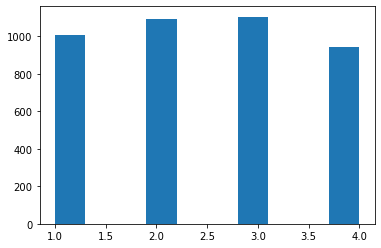

In [42]:
plt.figure()
plt.hist(ypred_test)
plt.show()


In [43]:
df = pd.DataFrame
test_labels['price'] = ypred_test
test_labels['price'] = test_labels['price'].map(lambda x: int(x))

In [44]:
test_labels

,id,price
0,7715,2
1,13196,2
2,13194,2
3,4673,2
4,11325,2
...,...,...
4144,12921,2
4145,7174,2
4146,9240,3
4147,11663,1


In [45]:
test_labels.to_csv(r'./submission5.csv', index=False)